<a href="https://colab.research.google.com/github/neelkanthrawat/mlph2023-Exercises/blob/main/sheet09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sheet 9

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
from torch.utils.data import TensorDataset, DataLoader

# 2) Classifier Reweighting

(a)

In [2]:
path_LO='/content/ttbarj_LO.npy'
path_NLO='/content/ttbarj_NLO.npy'

data_LO = np.load(path_LO)
data_NLO = np.load(path_NLO)
print(data_LO.shape, data_NLO.shape)

(45115, 28) (57043, 28)


In [3]:
# combine LO and NLO into one array and shuffle it
data = np.concatenate((data_LO, data_NLO), axis=0)
labels = np.concatenate((np.zeros(data_LO.shape[0]), np.ones(data_NLO.shape[0])), axis=0)
print("labels:", labels)
idx = np.random.permutation(len(data))# this is fror shuffling I believe
data = data[idx,:]
labels=labels[idx,None]
print("labels now:", labels)

labels: [0. 0. 0. ... 1. 1. 1.]
labels now: [[0.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [4]:
data.shape

(102158, 28)

In [5]:
def preprocess(event, mean=None, std=None):
    if mean is None or std is None:
        mean = event.mean(axis=0, keepdims=True)
        std = event.std(axis=0, keepdims=True)
    event = (event - mean) / std
    return event, mean, std

def create_dataloader(data, labels, batchsize, shuffle, mean=None, std=None):
    data, mean, std = preprocess(data, mean, std)
    data = torch.tensor(data).float()
    labels = torch.tensor(labels)
    loader = DataLoader(TensorDataset(data, labels), batch_size=batchsize, shuffle=shuffle)
    return loader, mean, std

In [6]:
(0.7)*102158, (0.15)*102158

(71510.59999999999, 15323.699999999999)

In [62]:
# split into train, validation and test sets and create dataloaders
n1, n2 = 71000, 85000
batchsize = 2000###512
data_trn, data_val, data_tst = data[:n1,:], data[n1:n2,:], data[n2:,:]
labels_trn, labels_val, labels_tst = labels[:n1,:], labels[n1:n2,:], labels[n2:,:]

mean, std = None, None
loader_trn, mean, std = create_dataloader(data_trn, labels_trn, batchsize, True, mean=mean, std=std)
loader_tst, mean, std = create_dataloader(data_tst, labels_tst, batchsize, False, mean=mean, std=std)
loader_val, mean, std = create_dataloader(data_val, labels_val, batchsize, False, mean=mean, std=std)

In [64]:
# TODO: Implement and train classifier
import torch.nn as nn

import torch.nn as nn

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_prob=0.1):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = nn.LeakyReLU(negative_slope=0.05)#nn.Tanh()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = nn.LeakyReLU(negative_slope=0.05)#nn.Tanh()
        self.dropout2 = nn.Dropout(p=dropout_prob)

        # self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        # self.activation3 = nn.ReLU()
        # #self.dropout3 = nn.Dropout(p=dropout_prob)

        # self.layer4 = nn.Linear(hidden_size3, hidden_size3)  # Adding another hidden layer
        # self.activation4 = nn.ReLU()
        # #self.dropout4 = nn.Dropout(p=dropout_prob)

        self.layer5 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.activation2(x)
        x = self.dropout2(x)

        # x = self.layer3(x)
        # x = self.activation3(x)
        # #x = self.dropout3(x)

        # x = self.layer4(x)
        # x = self.activation4(x)
        #x = self.dropout4(x)

        x = self.layer5(x)
        x = self.sigmoid(x)
        return x


In [48]:
import torch
import torch.nn as nn

class BinaryClassifier_paper(nn.Module):
    def __init__(self, input_size, internal_size=256, num_layers=8):
        super(BinaryClassifier_paper, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, internal_size))
        layers.append(nn.LeakyReLU(negative_slope=0.01))

        for _ in range(num_layers - 2):  # -2 because of the input and output layers
            layers.append(nn.Linear(internal_size, internal_size))
            layers.append(nn.LeakyReLU(negative_slope=0.01))

        layers.append(nn.Linear(internal_size, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# checking something:
input_size = 28
internal_size = 256
num_layers = 8

model = BinaryClassifier_paper(input_size=input_size, internal_size=internal_size, num_layers=num_layers)

# Print the model architecture
print(model)


BinaryClassifier_paper(
  (model): Sequential(
    (0): Linear(in_features=28, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=256, out_features=1, bias=True)
    (15): Sigmoid()
  )
)


In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

def train_and_validate(model, train_loader, val_loader, num_epochs=10, device="cpu",
                       print_epoch=1, learning_rate=0.001, weight_decay=0.2):

    model.to(device)  # move the model to the specified device
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate, weight_decay=weight_decay)  # Adam optimizer
    train_losses = []  # List to store training losses for each epoch
    val_losses = []    # List to store validation losses for each epoch
    train_accuracies = []  # List to store training accuracies for each epoch
    val_accuracies = []    # List to store validation accuracies for each epoch

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss_epoch = 0.0
        correct_train = 0
        total_train = 0
        for inputs_1, labels_1 in train_loader:
            inputs, labels = inputs_1.to(device), labels_1.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))  # Binary Cross-Entropy Loss
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()

            # Calculate training accuracy
            predicted_train = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted_train == labels.float().view(-1, 1)).sum().item()

        # Validation
        model.eval()
        val_loss_epoch = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_1, labels_1 in val_loader:
                inputs, labels = inputs_1.to(device), labels_1.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().view(-1, 1))  # Binary Cross-Entropy Loss
                val_loss_epoch += loss.item()

                # Calculate validation accuracy
                predicted_val = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted_val == labels.float().view(-1, 1)).sum().item()

        # Average losses for the epoch
        avg_train_loss = train_loss_epoch / len(train_loader)
        avg_val_loss = val_loss_epoch / len(val_loader)
        train_accuracy = (correct_train / total_train) * 100
        val_accuracy = (correct_val / total_val) * 100

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print statistics
        if (epoch + 1) % print_epoch == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Training Loss: {avg_train_loss:.4f}, '
                  f'Training Accuracy: {train_accuracy:.2f}%, '
                  f'Validation Loss: {avg_val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.2f}%')

    print('Training complete!')

    return train_losses, val_losses



In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_validate_paper(model, train_loader, val_loader,
                             num_epochs=10, device="cpu",
                       print_epoch=1, learning_rate=0.001, weight_decay=0.2):

    model.to(device)  # Move the model to the specified device
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

    # Adam optimizer with specified beta1 and beta2
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay,
                           betas=(0.5, 0.9))  # Adjust beta1 and beta2 here

    # Learning rate scheduler: Reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    train_losses = []  # List to store training losses for each epoch
    val_losses = []    # List to store validation losses for each epoch
    train_accuracies = []  # List to store training accuracies for each epoch
    val_accuracies = []    # List to store validation accuracies for each epoch

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss_epoch = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))  # Binary Cross-Entropy Loss
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()

            # Calculate training accuracy
            predicted_train = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted_train == labels.float().view(-1, 1)).sum().item()

        # Validation
        model.eval()
        val_loss_epoch = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().view(-1, 1))  # Binary Cross-Entropy Loss
                val_loss_epoch += loss.item()

                # Calculate validation accuracy
                predicted_val = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted_val == labels.float().view(-1, 1)).sum().item()

        # Average losses for the epoch
        avg_train_loss = train_loss_epoch / len(train_loader)
        avg_val_loss = val_loss_epoch / len(val_loader)
        train_accuracy = (correct_train / total_train) * 100
        val_accuracy = (correct_val / total_val) * 100

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Learning rate scheduler step based on validation loss
        scheduler.step(avg_val_loss)

        # Print statistics
        if (epoch + 1) % print_epoch == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Training Loss: {avg_train_loss:}, '
                  f'Training Accuracy: {train_accuracy:}%, '
                  f'Validation Loss: {avg_val_loss:}, '
                  f'Validation Accuracy: {val_accuracy:}%')

    print('Training complete!')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):
  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")
  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
### model given in the paper:
# input_size = 28
# internal_size = 256
# num_layers = 8

# model_bce_paper=BinaryClassifier_paper(input_size, internal_size, num_layers=8)

# train_loss_bce_paper, val_loss_bce_paper, _,_=train_and_validate_paper(model_bce_paper,
#                                                                        loader_trn, loader_val,
#                                                                        num_epochs=200)

Epoch 20/200, Training Loss: 0.6493, Training Accuracy: 62.13%, Validation Loss: 0.6502, Validation Accuracy: 62.34%
Epoch 40/200, Training Loss: 0.6452, Training Accuracy: 62.60%, Validation Loss: 0.6481, Validation Accuracy: 62.49%
Epoch 60/200, Training Loss: 0.6433, Training Accuracy: 63.16%, Validation Loss: 0.6491, Validation Accuracy: 62.14%
Epoch 80/200, Training Loss: 0.6401, Training Accuracy: 63.44%, Validation Loss: 0.6488, Validation Accuracy: 62.53%
Epoch 100/200, Training Loss: 0.6394, Training Accuracy: 63.45%, Validation Loss: 0.6481, Validation Accuracy: 62.64%
Epoch 120/200, Training Loss: 0.6393, Training Accuracy: 63.47%, Validation Loss: 0.6468, Validation Accuracy: 62.64%
Epoch 140/200, Training Loss: 0.6382, Training Accuracy: 63.72%, Validation Loss: 0.6482, Validation Accuracy: 62.68%
Epoch 160/200, Training Loss: 0.6374, Training Accuracy: 63.61%, Validation Loss: 0.6472, Validation Accuracy: 62.49%
Epoch 180/200, Training Loss: 0.6374, Training Accuracy: 63.

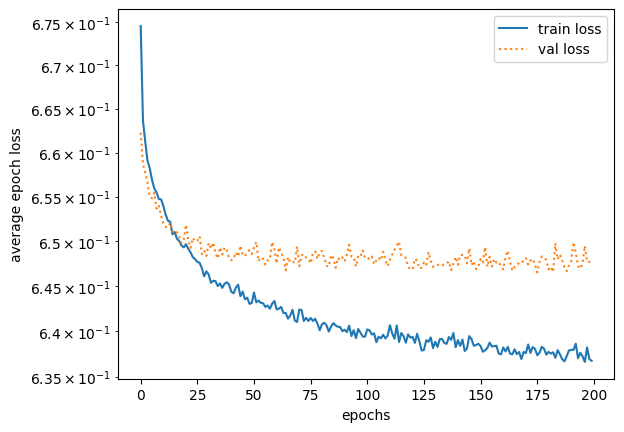

In [65]:
# defining the model
input_size = 28
hidden_size1, hidden_size2, hidden_size3 = 248,248,64# 124,64,64
output_size = 1
weight_decay=0.001
dropout_prob = 0.2# 0.4 worked somewhat well

model_bce = BinaryClassifier(input_size,
                             hidden_size1=hidden_size1,
                             hidden_size2=hidden_size2,
                             hidden_size3=hidden_size3,
                             output_size=output_size, dropout_prob=dropout_prob)

train_loss_bce, val_loss_bce= train_and_validate(model_bce,
                   train_loader=loader_trn, val_loader=loader_val,
                   num_epochs=200, device=device,
                    print_epoch=20, learning_rate=0.001, weight_decay=weight_decay)

plot_train_and_val_loss(train_loss_bce, val_loss_bce)

In [ ]:
# TODO: Evaluate classifier on test set.
# Visualize the classifier score. Compute ROC curve and AUC.

(c)

In [ ]:
# TODO: Compute weights of events in the test set.

In [ ]:
def get_pt(particle):
    return np.sqrt(particle[:,1]**2 + particle[:,2]**2)
def get_mass(particle):
    return np.sqrt(particle[:,0]**2 - np.sum(particle[:,1:]**2, axis=-1))
def get_top1(event):
    return event[:,:4] + event[:,4:8] + event[:,8:12]

In [ ]:
# TODO: Visualize transverse momentum (pt) and mass of the leading
# top quark, using the functions defined above.

# 3) Event Generation with a Variational Autoencoder

In [ ]:
!pip install wget

In [ ]:
# download data to folder data09
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data09"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-11-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data09

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

 tutorial-11-data/  'tutorial-11-data (1).zip'   tutorial-11-data.zip


In [ ]:
data_trn = np.load("data09/tutorial-11-data/dy_trn_data.npy")
data_tst = np.load("data09/tutorial-11-data/dy_tst_data.npy")
data_val = np.load("data09/tutorial-11-data/dy_val_data.npy")
print(data_trn.shape, data_tst.shape, data_val.shape)

(1384081, 8) (296588, 8) (296588, 8)


In [ ]:
# helper functions for collider kinematics
# used for plotting and the extended preprocessing in part (d)
def get_mass(particle):
    return np.sqrt(np.clip(particle[:,0]**2 - np.sum(particle[:,1:]**2, axis=-1), 0, None))

def get_pt(particle):
    return np.sqrt(particle[:,1]**2 + particle[:,2]**2)

def get_eta(particle):
    p_absolute = np.sqrt(np.sum(particle[:,1:]**2, axis=-1))
    return np.arctanh(particle[:,3] / p_absolute)

def get_phi(particle):
    return np.arctan2(particle[:,2], particle[:,1])

def get_pt_phi_eta_mass(particle):
    pt = get_pt(particle)
    phi = get_phi(particle)
    eta = get_eta(particle)
    mass = get_mass(particle)
    return np.stack((pt, phi, eta, mass), axis=-1)

(b)

In [ ]:
# TODO: Minimal preprocessing
def simple_preprocessing(data_in, mean=None, std=None):
  x= data_in.copy() # we dont want to overwrite

  if mean is None and std is None:
    mean= x.mean(keepdims=True)# need to check this keepdims thingy
    std= x.std(keepdims=True)

  x=(x-mean)/std# normalising the data
  assert torch.isfinite(x).all() if isinstance(x, torch.Tensor) else np.isfinite(x).all()
  return torch.Tensor(x).float() if isinstance(x, torch.Tensor) else x, mean, std


def undo_simple_preprocessing(preprocessed_x_in, mean, std):
  x_revert = preprocessed_x_in.clone() if isinstance(preprocessed_x_in, torch.Tensor) else np.copy(preprocessed_x_in)
  x_revert = x_revert * std + mean
  return torch.Tensor(x_revert).float() if isinstance(x_revert, np.ndarray) else x_revert


In [ ]:
checking_preprocess, mean_check, std_check= simple_preprocessing(data_trn)

In [ ]:
undo_prepro= undo_simple_preprocessing(checking_preprocess, mean_check, std_check)

In [ ]:
data_trn[:2], checking_preprocess[:2], undo_prepro[:2]

(array([[ 68.635   ,   8.6072  , -43.4797  , -52.4042  , 100.88    ,
          -8.6072  ,  43.4797  , -90.6211  ],
        [ 50.8114  ,  -0.360518, -35.1056  , -36.7324  ,  41.6698  ,
           0.360518,  35.1056  ,  22.4464  ]]),
 array([[ 0.75447332, -0.17800474, -0.98712803, -1.12576214,  1.25537049,
         -0.44541501,  0.36370829, -1.71942742],
        [ 0.47759967, -0.3173102 , -0.8570439 , -0.88231478,  0.33559311,
         -0.30610955,  0.23362415,  0.03697483]]),
 tensor([[ 68.6350,   8.6072, -43.4797, -52.4042, 100.8800,  -8.6072,  43.4797,
          -90.6211],
         [ 50.8114,  -0.3605, -35.1056, -36.7324,  41.6698,   0.3605,  35.1056,
           22.4464]]))

simple_preprocessing is done. let's proceed further

Creating a VAE architecture

In [ ]:
### creating the encoder for the VAE
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.5):
        super(VAEEncoder, self).__init__()

        self.fc1 = nn.Linear(input_dim,hidden_dim) #64)
        #self.fc2 = nn.Linear(64, 32)
        #self.fc3 = nn.Linear(32, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(hidden_dim, latent_dim)
        self.kl=0
        #self.dropout = nn.Dropout(p=dropout_rate)

        #self.Normal= torch.distributions.Normal(0,1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        #x = torch.relu(self.fc2(x))
        #x = self.dropout(x)
        #x = torch.relu(self.fc3(x))
        #x = self.dropout(x)
        mu = self.fc_mu(x)
        sigma = torch.exp(self.fc_sigma(x))# torch.exp to keep the values positive
        #z= mu+sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * torch.sum(sigma**2 + mu**2 - torch.log(sigma**2) - 1)
        return mu, sigma


In [ ]:
# creating the decoder for the VAE
import torch
import torch.nn as nn

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(VAEDecoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        #self.fc2 = nn.Linear(hidden_dim, 32)
        #self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
        #self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        #z = self.dropout(z)
        #z = torch.relu(self.fc2(z))
        #z = self.dropout(z)
        #z = torch.relu(self.fc3(z))
        #z = self.dropout(z)
        reconstruction = self.tanh(self.fc4(z))
        return reconstruction

In [ ]:
# defining our VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.5):
        super(VAE, self).__init__()

        self.encoder = VAEEncoder(input_dim, hidden_dim, latent_dim, dropout_rate)
        self.decoder = VAEDecoder(latent_dim, hidden_dim, input_dim, dropout_rate)

    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        reconstruction = self.decoder(z)
        return reconstruction, mu, sigma

In [ ]:
def loss_function_vae(vae_model, x_reconst, x_true, beta_kl=1):
  first_term= torch.sum((x_reconst-x_true)**2)
  loss=  first_term+ beta_kl* vae_model.encoder.kl
  return loss

# import torch.nn.functional as F

# def loss_function_vae(vae_model, x_reconst, x_true, beta_kl=1):
#     # Move input tensors to the same device as the model
#     x_reconst = x_reconst.to(vae_model.device)
#     x_true = x_true.to(vae_model.device)

#     first_term = F.binary_cross_entropy(x_reconst, x_true, reduction="sum")
#     loss = first_term + beta_kl * vae_model.encoder.kl
#     return loss

In [ ]:
### simple preprocessing
data_trn_preprocessed, mean_trn, std_trn= simple_preprocessing(data_trn[:500000])
data_val_preprocessed, mean_val, std_val = simple_preprocessing(data_val[:5000])
data_tst_preprocessed, mean_tst, std_tst = simple_preprocessing(data_tst[:5000])

print(type(data_trn), type(data_trn_preprocessed))

# converting to torch tensors
data_trn_torch= torch.Tensor(data_trn_preprocessed)
data_val_torch= torch.Tensor(data_val_preprocessed)
data_tst_torch= torch.Tensor(data_tst_preprocessed)
print(type(data_trn_torch))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [ ]:
import torch
import torch.optim as optim

def train_and_validate_vae(model, train_dataloader, val_dataloader, num_epochs=10,
                       learning_rate=0.001, device="cpu", print_epoch=5, beta_kl=1):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the specified device
    model.to(device)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        #print(f"epoch :{epoch}")
        model.train()
        running_train_loss = 0.0

        for batch_idx, data in enumerate(train_dataloader, 1):
            inputs = data.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(inputs)

            # Calculate the loss using your predefined function
            loss = loss_function_vae(model, recon_batch, inputs, beta_kl)

            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        average_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                inputs = data.to(device)
                recon_batch, mu, logvar = model(inputs)
                running_val_loss += loss_function_vae(model, recon_batch, inputs, beta_kl).item()

        # Calculate average validation loss for the epoch
        average_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(average_val_loss)

        # Print training and validation losses
        if epoch % print_epoch == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {average_train_loss}, Validation Loss: {average_val_loss}")

    print("Training finished.")

    # we will return the recorded losses
    return train_losses, val_losses


In [ ]:
### creating dataloaders
from torch.utils.data import DataLoader
batch_size=64
trn_dataloader= DataLoader(data_trn_torch, batch_size=batch_size, shuffle=True)
val_dataloader= DataLoader(data_val_torch,batch_size=batch_size, shuffle=False)
tst_dataloader= DataLoader(data_tst_torch,batch_size=batch_size, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):
  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")
  if want_logscale:
    plt.yscale('log')
  plt.legend()

Epoch [1/20], Train Loss: 312.8714174285033, Validation Loss: 283.6219238570974
Epoch [2/20], Train Loss: 285.7562684445227, Validation Loss: 281.37879683096196
Epoch [3/20], Train Loss: 284.2488353655522, Validation Loss: 281.0894432550744
Epoch [4/20], Train Loss: 283.7730162398513, Validation Loss: 280.4540754149232
Epoch [5/20], Train Loss: 283.6073363121167, Validation Loss: 280.23694982407966
Epoch [6/20], Train Loss: 283.7542470309244, Validation Loss: 280.42640253863755
Epoch [7/20], Train Loss: 283.51963664169244, Validation Loss: 279.6593378284309
Epoch [8/20], Train Loss: 283.4918915990158, Validation Loss: 279.71625774721554
Epoch [9/20], Train Loss: 283.53353752352035, Validation Loss: 281.2950643949871
Epoch [10/20], Train Loss: 283.30480560376947, Validation Loss: 279.838436126709
Epoch [11/20], Train Loss: 283.5677654540266, Validation Loss: 280.42846380306196
Epoch [12/20], Train Loss: 283.40250985655666, Validation Loss: 278.91478050811384
Epoch [13/20], Train Loss: 2

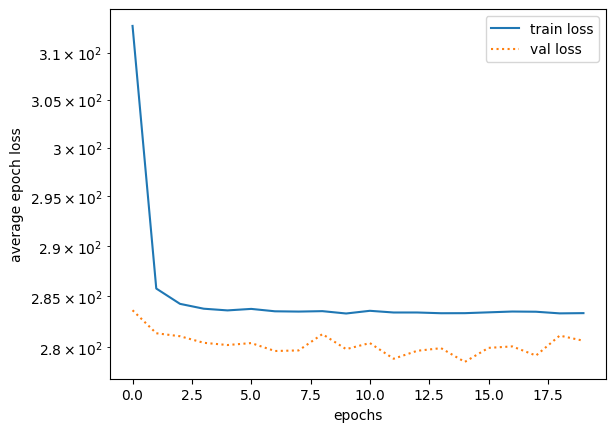

In [ ]:
### training

model_vae= VAE(input_dim=8, hidden_dim=7, latent_dim=6, dropout_rate=0.1)

train_loss_vae, val_loss_vae= train_and_validate_vae(model=model_vae,
                                                     train_dataloader=trn_dataloader,
                                                     val_dataloader=val_dataloader,
                                                     num_epochs=20,learning_rate=0.0005,
                                                     device=device,
                                                     print_epoch=1)

plot_train_and_val_loss(train_loss_vae, val_loss_vae)

In [ ]:
# generate the dataset
def generate_samples(model, num_samples, device="cpu"):
    model.eval()

    # Sample from the latent space
    with torch.no_grad():
        z_samples = torch.randn(num_samples, model.encoder.fc_mu.out_features).to(device)

    # Decode the samples
    with torch.no_grad():
        generated_samples = model.decoder(z_samples)

    return generated_samples


In [ ]:
samples_generated=generate_samples(model=model_vae, num_samples=200000, device=device)

samples_generated_undo_preprocess=undo_simple_preprocessing(preprocessed_x_in=samples_generated.cpu(),
                                                            mean=mean_trn,
                                                            std=std_trn)

In [ ]:
type(samples_generated_undo_preprocess), samples_generated_undo_preprocess.shape

(torch.Tensor, torch.Size([200000, 8]))

In [ ]:
with torch.no_grad():
  reconstructed_samples, _, _ = model_vae(data_trn_torch.to(device))

In [ ]:
# helper function for plotting
# takes two sets of events (truth/train, generated)
# of shape (n, 28) as input
components_Eppp = ["E [GeV]", "px [GeV]", "py [GeV]", "pz [GeV]"]
components_jetcoordinates = ["pt [GeV]", "phi", "eta", "mass [GeV]"]
def plot(truth, generated, bins=20):
    fig, axs = plt.subplots(4,4, figsize=(15,15))

    # plot (E, px, py, pz) for both particles
    for iparticle in range(2):
        for icomponent in range(4):
            ax = axs[iparticle, icomponent]
            xlabel = f"{components_Eppp[icomponent]} of particle {iparticle+1}"
            i = iparticle*4 + icomponent

            bins_local = bins
            _, bins_local, _ = ax.hist(truth[:,i], bins=bins_local, alpha=.5, label="truth", density=True)
            ax.hist(generated[:,i], bins=bins_local, alpha=.5, label="model", density=True)
            ax.legend()
            ax.set_xlabel(xlabel)

    # plot (pt phi eta mass) for both particles
    truth = np.concatenate((get_pt_phi_eta_mass(truth[:,:4]),
                            get_pt_phi_eta_mass(truth[:,4:])), axis=-1)
    generated = np.concatenate((get_pt_phi_eta_mass(generated[:,:4]),
                                get_pt_phi_eta_mass(generated[:,4:])), axis=-1)
    for iparticle in range(2):
        for icomponent in range(4):
            ax = axs[2+iparticle, icomponent]
            xlabel = f"{components_jetcoordinates[icomponent]} of particle {iparticle+1}"
            i = iparticle*4 + icomponent

            bins_local = bins
            _, bins_local, _ = ax.hist(truth[:,i], bins=bins_local, alpha=.5, label="truth", density=True)
            ax.hist(generated[:,i], bins=bins_local, alpha=.5, label="model", density=True)
            ax.legend()
            ax.set_xlabel(xlabel)

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


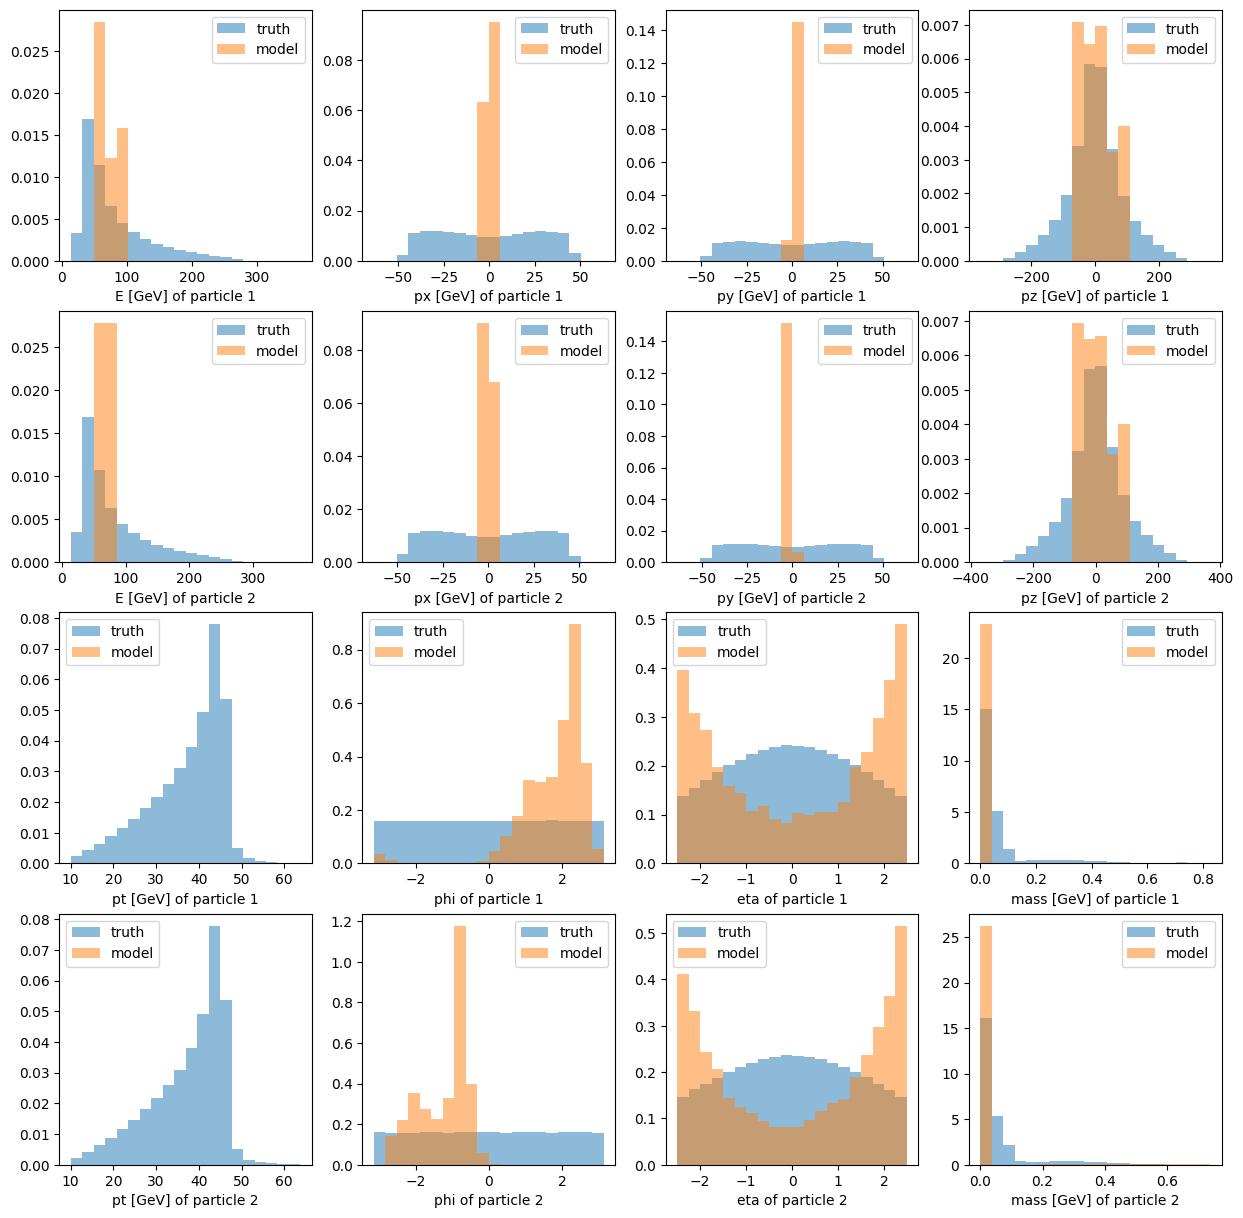

In [ ]:
plot(data_trn, samples_generated_undo_preprocess.numpy())

(c)

In [ ]:
# TODO: Test mass and momentum conservation

In [ ]:
samples_generated.shape

torch.Size([200000, 8])

In [ ]:
samples_generated

tensor([[ 0.9996, -0.3078, -0.3075,  ..., -0.3147, -0.3151, -1.0000],
        [ 0.5261, -0.3129, -0.3065,  ..., -0.3070, -0.3139, -0.2590],
        [ 0.6663, -0.3128, -0.3103,  ..., -0.3145, -0.3164, -0.8448],
        ...,
        [ 0.5207, -0.3131, -0.3100,  ..., -0.3112, -0.3142, -0.3821],
        [ 1.0000, -0.3075, -0.3097,  ..., -0.3188, -0.3162, -1.0000],
        [ 0.5624, -0.3161, -0.3041,  ..., -0.3041, -0.3166,  0.0375]],
       device='cuda:0')

### checking momentum in x direction

let's first check the data_trn

In [ ]:
data_trn[:,1], data_trn[:,5], data_trn[:,1]+data_trn[:,5]

(array([  8.6072  ,  -0.360518,  35.6932  , ..., -34.1883  ,  42.4301  ,
        -25.0749  ]),
 array([ -8.6072  ,   0.360518, -35.6932  , ...,  34.1883  , -42.4301  ,
         25.0749  ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
### checking with the preprocessed data
data_trn_preprocessed[:,1], data_trn_preprocessed[:,5]

(array([-0.17784317, -0.31714965,  0.24291662, ...,  0.20400496,
         0.09151238,  0.00901792]),
 array([-0.44525539, -0.30594892, -0.86601519, ..., -0.82710353,
        -0.71461094, -0.63211649]))

In [ ]:
data_trn_preprocessed[:,1]+data_trn_preprocessed[:,5]

array([-0.62309857, -0.62309857, -0.62309857, ..., -0.62309857,
       -0.62309857, -0.62309857])

now let's check with the generated samples

In [ ]:
samples_generated[:,1], samples_generated[:,5]

(tensor([-0.3078, -0.3129, -0.3128,  ..., -0.3131, -0.3075, -0.3161],
        device='cuda:0'),
 tensor([-0.3147, -0.3070, -0.3145,  ..., -0.3112, -0.3188, -0.3041],
        device='cuda:0'))

In [ ]:
samples_generated[:,1]+samples_generated[:,5]

tensor([-0.6225, -0.6199, -0.6272,  ..., -0.6243, -0.6263, -0.6202],
       device='cuda:0')

In [ ]:
samples_generated_undo_preprocess=undo_simple_preprocessing(preprocessed_x_in=samples_generated.cpu(),
                                                            mean=mean_trn,
                                                            std=std_trn)

In [ ]:
samples_generated_undo_preprocess[:,1],samples_generated_undo_preprocess[:,5]

(tensor([ 0.2403, -0.0859, -0.0776,  ..., -0.0971,  0.2615, -0.2917],
        dtype=torch.float64),
 tensor([-0.2007,  0.2941, -0.1882,  ...,  0.0229, -0.4653,  0.4809],
        dtype=torch.float64))

In [ ]:
samples_generated_undo_preprocess[:,1]+samples_generated_undo_preprocess[:,5]

tensor([ 0.0395,  0.2083, -0.2658,  ..., -0.0742, -0.2038,  0.1892],
       dtype=torch.float64)

### checking momentum in y direction

once again let's first check the data

In [ ]:
data_trn[:,2], data_trn[:,6]

(array([-43.4797 , -35.1056 , -22.1602 , ..., -20.5728 ,   1.75781,
         35.1042 ]),
 array([ 43.4797 ,  35.1056 ,  22.1602 , ...,  20.5728 ,  -1.75781,
        -35.1042 ]))

In [ ]:
data_trn[:,2]+data_trn[:,6]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
data_trn_preprocessed[:,2], data_trn_preprocessed[:,6]

(array([-0.98697237, -0.85688728, -0.65579063, ..., -0.57373735,
         0.14967249,  0.18264075]),
 array([ 0.3638738 ,  0.23378872,  0.03269207, ..., -0.04936122,
        -0.77277105, -0.80573932]))

In [ ]:
data_trn_preprocessed[:,2]+data_trn_preprocessed[:,6]

array([-0.62309857, -0.62309857, -0.62309857, ..., -0.62309857,
       -0.62309857, -0.62309857])

let's check the generated events

In [ ]:
samples_generated[:,2], samples_generated[:,6]

(tensor([-0.3075, -0.3065, -0.3103,  ..., -0.3100, -0.3097, -0.3041],
        device='cuda:0'),
 tensor([-0.3151, -0.3139, -0.3164,  ..., -0.3142, -0.3162, -0.3166],
        device='cuda:0'))

In [ ]:
samples_generated[:,2] + samples_generated[:,6]

tensor([-0.6226, -0.6204, -0.6267,  ..., -0.6241, -0.6259, -0.6207],
       device='cuda:0')

In [ ]:
samples_generated_undo_preprocess[:,2]+samples_generated_undo_preprocess[:,6]

tensor([ 0.0328,  0.1769, -0.2314,  ..., -0.0674, -0.1812,  0.1565],
       dtype=torch.float64)

(e)

In [ ]:
# cuts in the dataset
get_pt(data_tst[:,:4]).min(), get_pt(data_tst[:,4:]).min() # pt cuts
get_eta(data_tst[:,:4]).min(), get_eta(data_tst[:,:4]).max()

eta_cut = 2.5 + 1e-5 # should be 2.5 but one event is weird
pt_cut = 10.

In [ ]:
def preprocess2(events, mean=None, std=None):
    particle1, particle2 = events[:,:4], events[:,4:]
    events_jetcoordinates = np.stack((get_pt(particle1), get_phi(particle1), get_eta(particle1), get_mass(particle1), get_pt(particle2), get_phi(particle2), get_eta(particle2), get_mass(particle2)), axis=-1)
    events_reduced = events_jetcoordinates[:,[0,2,6]]

    events_reduced[:,0] = np.log(events_reduced[:,0] - pt_cut)
    events_reduced[:,1:] = np.arctanh(events_reduced[:,1:] / eta_cut)

    if mean is None or std is None:
        mean = events_reduced.mean(axis=0)
        std = events_reduced.std(axis=0)
    events_reduced = (events_reduced - mean) / std

    assert np.isfinite(events_reduced).all()
    return events_reduced, mean, std

def undo_preprocess2(events_reduced, mean, std):
    events_reduced = events_reduced * std + mean

    events_reduced[:,0] = np.exp(events_reduced[:,0]) + pt_cut
    events_reduced[:,[1,2]] = np.tanh(events_reduced[:,[1,2]]) * eta_cut

    pt1, eta1, eta2 = events_reduced.T
    phi1 = np.random.uniform(0, 2*np.pi, events_reduced.shape[0])
    mass1, mass2 = np.ones((2, events_reduced.shape[0])) * 0.105
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    e1 = np.sqrt(mass1**2 + px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pt2 = pt1
    pz2 = pt2 * np.sinh(eta2)
    e2 = np.sqrt(mass2**2 + px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

In [ ]:
# TODO: Train VAE on dataset with extended preprocessing

In [ ]:
### simple preprocessing
data_trn_preprocessed_2, mean_trn_2, std_trn_2= preprocess2(data_trn[:500000])
data_val_preprocessed_2, mean_val_2, std_val_2 = preprocess2(data_val[:5000])
data_tst_preprocessed_2, mean_tst_2, std_tst_2 = preprocess2(data_tst[:5000])

print(type(data_trn), type(data_trn_preprocessed_2))

# converting to torch tensors
data_trn_torch_2= torch.Tensor(data_trn_preprocessed_2)
data_val_torch_2= torch.Tensor(data_val_preprocessed_2)
data_tst_torch_2= torch.Tensor(data_tst_preprocessed_2)
print(type(data_trn_torch_2))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [ ]:
np.shape(data_trn_preprocessed_2)

(500000, 3)

In [ ]:
### creating dataloaders
from torch.utils.data import DataLoader
batch_size=64
trn_dataloader_2= DataLoader(data_trn_torch_2, batch_size=batch_size, shuffle=True)
val_dataloader_2= DataLoader(data_val_torch_2,batch_size=batch_size, shuffle=False)
tst_dataloader_2= DataLoader(data_tst_torch_2,batch_size=batch_size, shuffle=False)

Using cuda device
Epoch [1/20], Train Loss: 196.23640924285533, Validation Loss: 189.8961822896064
Epoch [2/20], Train Loss: 192.00011433447946, Validation Loss: 189.90532114535947
Epoch [3/20], Train Loss: 192.0027687793411, Validation Loss: 189.88487948647028
Epoch [4/20], Train Loss: 191.99503016181964, Validation Loss: 189.71417308759086
Epoch [5/20], Train Loss: 187.74549392120153, Validation Loss: 184.08912204790718
Epoch [6/20], Train Loss: 178.05396843371557, Validation Loss: 172.09722642053532
Epoch [7/20], Train Loss: 173.27179626617178, Validation Loss: 171.6002871839306
Epoch [8/20], Train Loss: 173.24532264993636, Validation Loss: 172.16646730447118
Epoch [9/20], Train Loss: 173.1357674720146, Validation Loss: 171.14119546624678
Epoch [10/20], Train Loss: 173.14732089763442, Validation Loss: 171.9058682405496
Epoch [11/20], Train Loss: 173.09881599706526, Validation Loss: 171.0776759763307
Epoch [12/20], Train Loss: 173.10775642292487, Validation Loss: 171.18880544734907
E

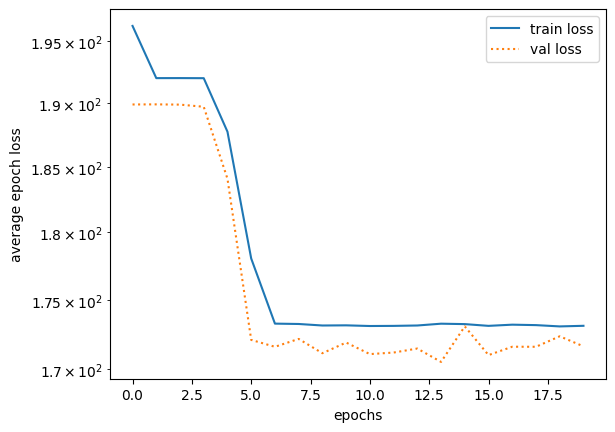

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model_vae_2= VAE(input_dim=3, hidden_dim=2, latent_dim=2, dropout_rate=0.1)

train_loss_vae_2, val_loss_vae_2= train_and_validate_vae(model=model_vae_2,
                                                     train_dataloader=trn_dataloader_2,
                                                     val_dataloader=val_dataloader_2,
                                                     num_epochs=20,learning_rate=0.0005,
                                                     device=device,
                                                     print_epoch=1)

plot_train_and_val_loss(train_loss_vae_2, val_loss_vae_2)

In [ ]:
samples_generated_2=generate_samples(model=model_vae_2, num_samples=200000, device=device)

In [ ]:
samples_generated_2_undo_preprocessing= undo_preprocess2(samples_generated_2.cpu().numpy(),
                                                         mean=mean_trn_2,
                                                         std=std_trn_2)

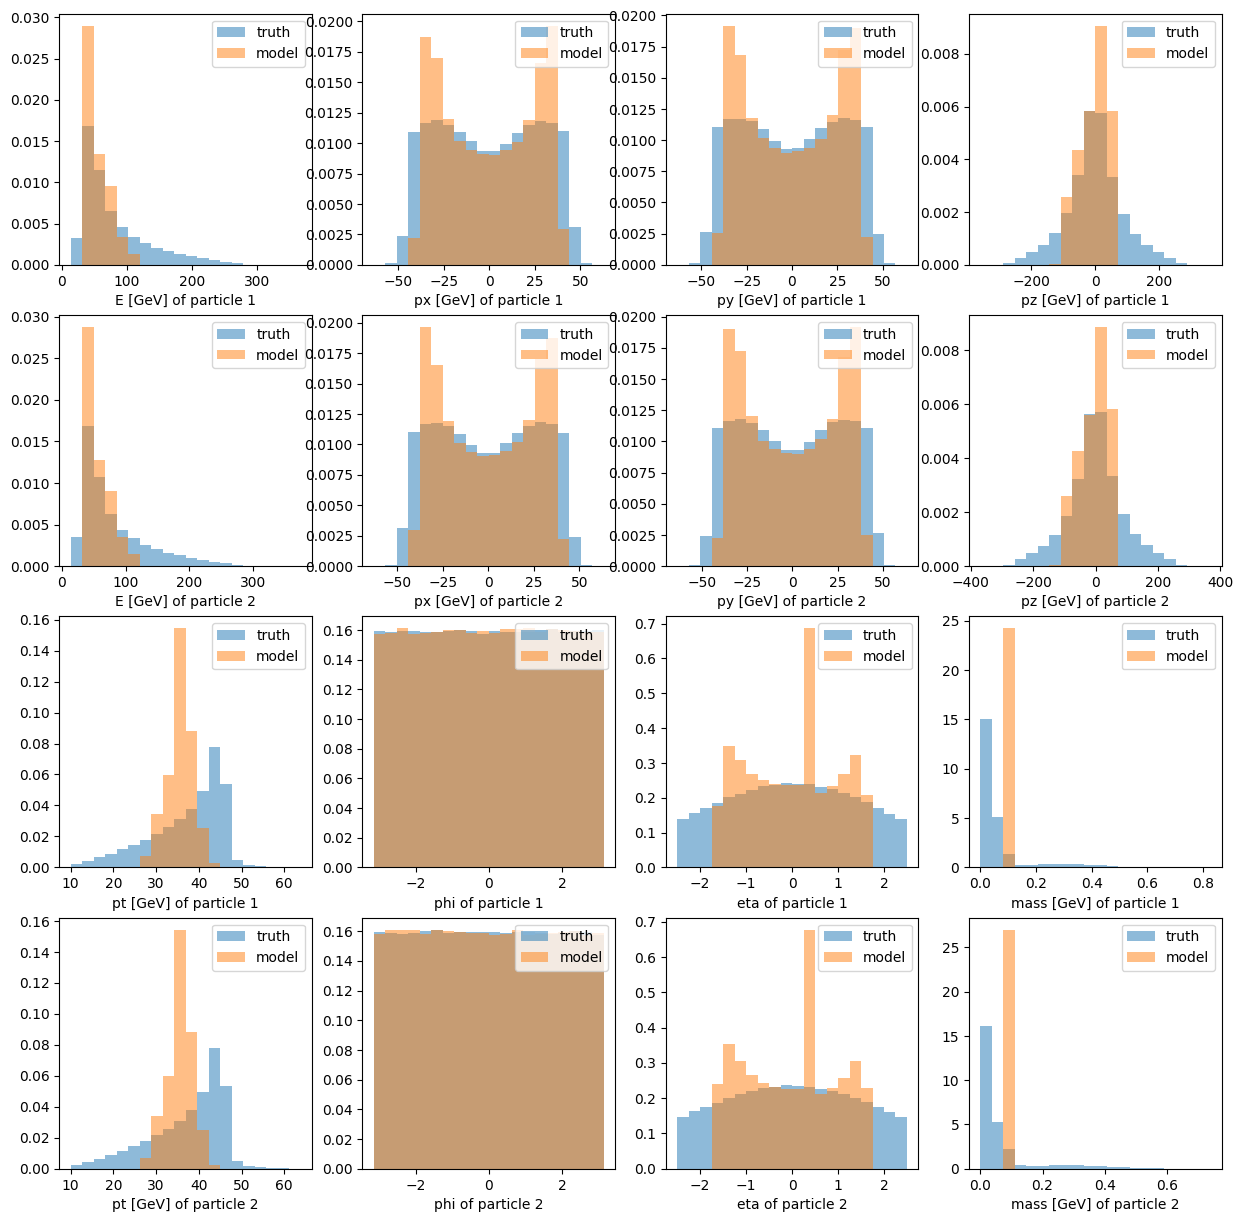

In [ ]:
plot(data_trn, samples_generated_2_undo_preprocessing)

Let's check the momentum conservation in the transverse direction.

In [ ]:
samples_generated_2_undo_preprocessing[:,1], samples_generated_2_undo_preprocessing[:,5]

(array([ 38.37059577, -35.27340483, -30.8445457 , ..., -34.39184683,
         29.07305033, -32.28765794]),
 array([-38.37059577,  35.27340483,  30.8445457 , ...,  34.39184683,
        -29.07305033,  32.28765794]))

In [ ]:
samples_generated_2_undo_preprocessing[:,1]+samples_generated_2_undo_preprocessing[:,5]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
samples_generated_2_undo_preprocessing[:,2], samples_generated_2_undo_preprocessing[:,6]

(array([ -3.03133867,   1.19981512,  18.42983765, ...,  -7.92802096,
         22.20312777, -18.46312934]),
 array([  3.03133867,  -1.19981512, -18.42983765, ...,   7.92802096,
        -22.20312777,  18.46312934]))

In [ ]:
samples_generated_2_undo_preprocessing[:,2]+samples_generated_2_undo_preprocessing[:,6]

array([0., 0., 0., ..., 0., 0., 0.])